#📌 Extracción

In [7]:
# ==========================
# EXTRACCIÓN
# ==========================
import json, warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

DATA_PATH = Path("TelecomX_Data.json")  # tu archivo local
assert DATA_PATH.exists(), f"No encuentro {DATA_PATH.resolve()}"

# Carga robusta: maneja lista de dicts o dict con clave 'data'
try:
    df = pd.read_json(DATA_PATH)
    if isinstance(df, dict) or (df.columns.size == 1 and df.columns[0] == 0):
        # si read_json no infiere bien, cargamos manual
        with open(DATA_PATH, "r", encoding="utf-8") as f:
            payload = json.load(f)
        if isinstance(payload, dict) and "data" in payload:
            payload = payload["data"]
        df = pd.DataFrame(payload)
except ValueError:
    with open(DATA_PATH, "r", encoding="utf-8") as f:
        payload = json.load(f)
    if isinstance(payload, dict) and "data" in payload:
        payload = payload["data"]
    df = pd.DataFrame(payload)

print(f"[INFO] Registros cargados: {len(df):,}")
display(df.head(3))
print("\n[INFO] Columnas y tipos iniciales:\n")
print(df.dtypes)


[INFO] Registros cargados: 7,267


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



[INFO] Columnas y tipos iniciales:

customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object


#🔧 Transformación

In [12]:
# ==========================
# TRANSFORMACIÓN
# ==========================
import re
import numpy as np
import pandas as pd

df_tr = df.copy()  # df viene de la sección de Extracción

# 1) Aplanar columnas dict (customer, phone, internet, account)
dict_cols = [c for c in df_tr.columns if df_tr[c].apply(lambda x: isinstance(x, dict)).any()]
flat_parts = [df_tr[[c for c in df_tr.columns if c not in dict_cols]].copy()]

for c in dict_cols:
    tmp = pd.json_normalize(df_tr[c]).add_prefix(f"{c}.")  # ej. customer.gender → customer.gender
    flat_parts.append(tmp)

df_tr = pd.concat(flat_parts, axis=1)

# 2) Normalizar nombres a snake_case y puntos → guion_bajo
def snake(s):
    s = re.sub(r"[^\w]+", "_", s)      # no alfanum
    s = re.sub(r"__+", "_", s).strip("_")
    return s.lower()

df_tr.columns = [snake(c) for c in df_tr.columns]

# 3) Elegir columnas clave aunque vengan con prefijos (customer_, account_, etc.)
def take_first_suffix(df_, suffixes):
    """Devuelve el primer match por sufijo disponible en df_.columns"""
    matches = []
    for suf in suffixes if isinstance(suffixes, (list, tuple)) else [suffixes]:
        matches += [c for c in df_.columns if c.endswith(suf)]
    return matches[0] if matches else None

cols_map = {
    "customer_id"       : ["customerid","customer_id"],
    "churn"             : ["churn"],
    "gender"            : ["gender","customer_gender"],
    "senior_citizen"    : ["seniorcitizen","senior_citizen","customer_seniorcitizen"],
    "partner"           : ["partner","customer_partner"],
    "dependents"        : ["dependents","customer_dependents"],
    "tenure_months"     : ["tenure","tenure_months","customer_tenure","account_tenure"],
    "phone_service"     : ["phone_service","phoneservice","phone_phoneservice"],
    "multiple_lines"    : ["multiplelines","multiple_lines","phone_multiplelines"],
    "internet_service"  : ["internetservice","internet_service","internet_internetservice"],
    "online_security"   : ["onlinesecurity","online_security","internet_onlinesecurity"],
    "online_backup"     : ["onlinebackup","online_backup","internet_onlinebackup"],
    "device_protection" : ["deviceprotection","device_protection","internet_deviceprotection"],
    "tech_support"      : ["techsupport","tech_support","internet_techsupport"],
    "streaming_tv"      : ["streamingtv","streaming_tv","internet_streamingtv"],
    "streaming_movies"  : ["streamingmovies","streaming_movies","internet_streamingmovies"],
    "contract_type"     : ["contract","contract_type","account_contract"],
    "paperless_billing" : ["paperlessbilling","paperless_billing","account_paperlessbilling"],
    "payment_method"    : ["paymentmethod","payment_method","account_paymentmethod"],
    "monthly_charges"   : ["charges_monthly","account_charges_monthly","charges_monthly_"],
    "total_charges"     : ["charges_total","account_charges_total","charges_total_"],
}

df_std = pd.DataFrame(index=df_tr.index)
for out_col, suffixes in cols_map.items():
    src = take_first_suffix(df_tr, suffixes)
    if src:
        df_std[out_col] = df_tr[src]

# 3.1 Si las 'charges' venían como account.charges.{Monthly,Total} anidadas, intenta ese patrón:
if "monthly_charges" not in df_std.columns:
    cand = [c for c in df_tr.columns if c.endswith("charges_monthly") or c.endswith("charges_monthly_")]
    if cand: df_std["monthly_charges"] = df_tr[cand[0]]

if "total_charges" not in df_std.columns:
    cand = [c for c in df_tr.columns if c.endswith("charges_total") or c.endswith("charges_total_")]
    if cand: df_std["total_charges"] = df_tr[cand[0]]

# 4) Tipificación numérica
for col in ["monthly_charges","total_charges","tenure_months","senior_citizen"]:
    if col in df_std.columns:
        df_std[col] = pd.to_numeric(df_std[col], errors="coerce")

# 5) Normalización Sí/No → 1/0
YES = {"yes","y","si","sí","true","1"}
NO  = {"no","n","false","0"}

def yesno_to_bin(s):
    s = s.astype(str).str.strip().str.lower().replace({"nan": np.nan})
    return s.map(lambda x: 1 if x in YES else (0 if x in NO else np.nan))

for c in [
    "churn","partner","dependents","phone_service","multiple_lines","online_security",
    "online_backup","device_protection","tech_support","streaming_tv","streaming_movies",
    "paperless_billing"
]:
    if c in df_std.columns:
        df_std[c + "_bin"] = yesno_to_bin(df_std[c])

# 6) Senior citizen a 0/1 si venía raro
if "senior_citizen" in df_std.columns:
    vals = set(pd.unique(df_std["senior_citizen"].dropna()))
    if not vals.issubset({0,1}):
        df_std["senior_citizen"] = (pd.to_numeric(df_std["senior_citizen"], errors="coerce").fillna(0) >= 1).astype(int)

# 7) Imputar total_charges faltantes (tenure=0) y cap outliers suaves
if set(["total_charges","monthly_charges","tenure_months"]).issubset(df_std.columns):
    mask = df_std["total_charges"].isna()
    df_std.loc[mask, "total_charges"] = df_std.loc[mask, "monthly_charges"] * df_std.loc[mask, "tenure_months"]

for c in ["monthly_charges","total_charges"]:
    if c in df_std.columns:
        q1, q3 = df_std[c].quantile([0.01, 0.99])
        df_std[c] = df_std[c].clip(lower=q1, upper=q3)

# 8) Cuentas_Diarias
if "monthly_charges" in df_std.columns:
    df_std["cuentas_diarias"] = df_std["monthly_charges"] / 30.0

# 9) Chequeos rápidos
duplicados = df_std.duplicated(subset=["customer_id"]).sum() if "customer_id" in df_std.columns else 0
print(f"[INFO] Duplicados por customer_id: {duplicados}")
print("[INFO] Nulos por columna (Top 10):")
display(df_std.isna().sum().sort_values(ascending=False).head(10))

print("\n[INFO] Vista rápida:")
display(df_std.head(3))

# Deja listo para la siguiente sección:
df_ready = df_std.copy()


[INFO] Duplicados por customer_id: 0
[INFO] Nulos por columna (Top 10):


,0
streaming_movies_bin,1581
streaming_tv_bin,1581
device_protection_bin,1581
tech_support_bin,1581
online_security_bin,1581
online_backup_bin,1581
multiple_lines_bin,707
churn_bin,224
churn,0
customer_id,0



[INFO] Vista rápida:


,customer_id,churn,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_bin,partner_bin,dependents_bin,phone_service_bin,multiple_lines_bin,online_security_bin,online_backup_bin,device_protection_bin,tech_support_bin,streaming_tv_bin,streaming_movies_bin,paperless_billing_bin,cuentas_diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0.0,1,1,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0.0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1.0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2.463333


#📊 Carga y análisis

[INFO] Nulos por columna (Top 10) tras ajustes:


,0
churn_bin,224
customer_id,0
churn,0
gender,0
partner,0
senior_citizen,0
tenure_months,0
phone_service,0
multiple_lines,0
dependents,0



[INFO] Descriptivo numérico:


,count,mean,std,min,25%,50%,75%,max
senior_citizen,7267.0,0.162653,0.369074,0.00,0.000000,0.000000,0.000000,1.000
tenure_months,7267.0,32.346498,24.571773,0.00,9.000000,29.000000,55.000000,72.000
monthly_charges,7267.0,64.709922,30.105156,19.20,35.425000,70.300000,89.875000,114.900
total_charges,7267.0,2274.682113,2261.963099,19.75,396.200000,1389.200000,3778.525000,8043.418
churn_bin,7043.0,0.265370,0.441561,0.00,0.000000,0.000000,1.000000,1.000
partner_bin,7267.0,0.484106,0.499782,0.00,0.000000,0.000000,1.000000,1.000
dependents_bin,7267.0,0.300124,0.458343,0.00,0.000000,0.000000,1.000000,1.000
phone_service_bin,7267.0,0.902711,0.296371,0.00,1.000000,1.000000,1.000000,1.000
multiple_lines_bin,7267.0,0.421770,0.493876,0.00,0.000000,0.000000,1.000000,1.000
online_security_bin,7267.0,0.285950,0.451897,0.00,0.000000,0.000000,1.000000,1.000



[INFO] Churn global (aprox): 26.54%


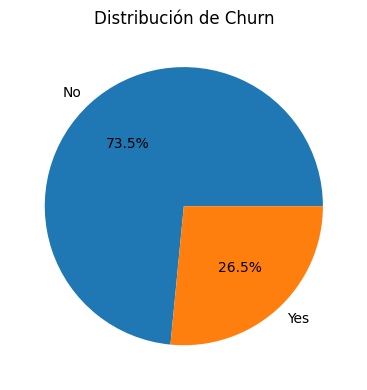

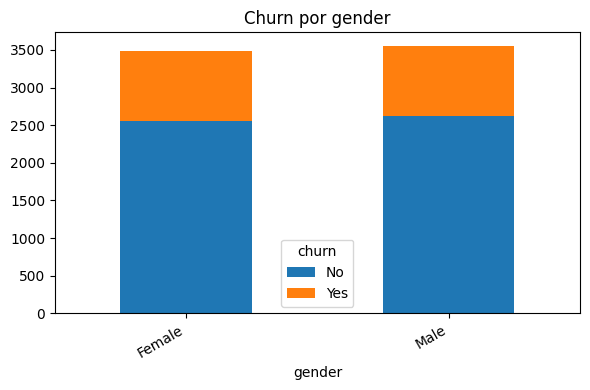

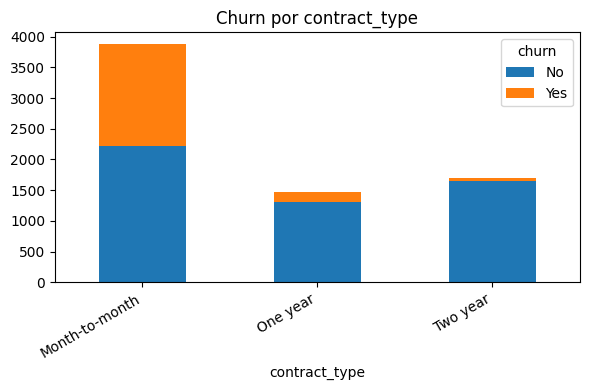

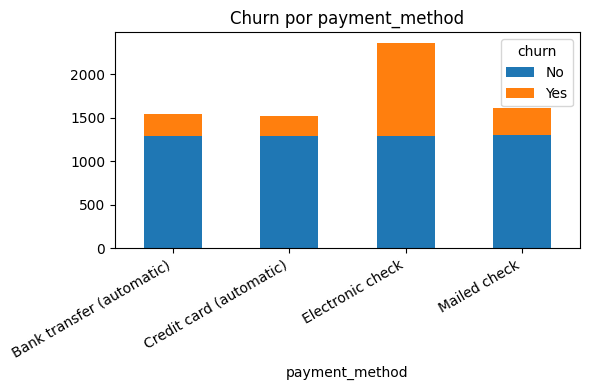

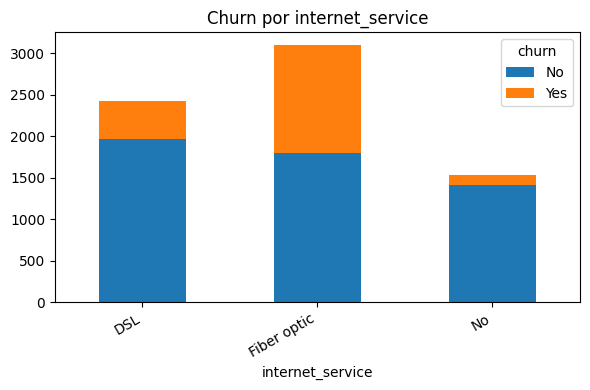

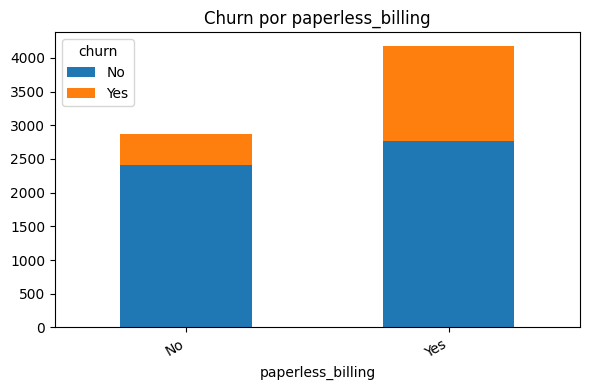

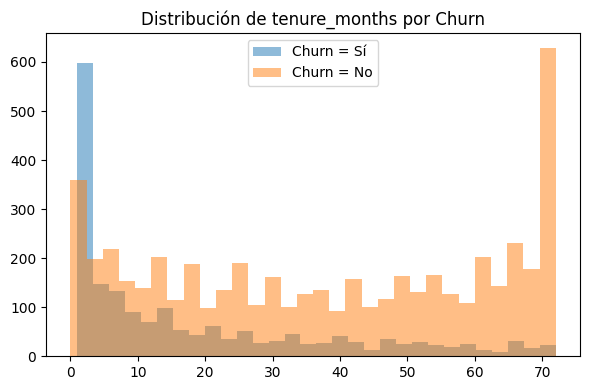

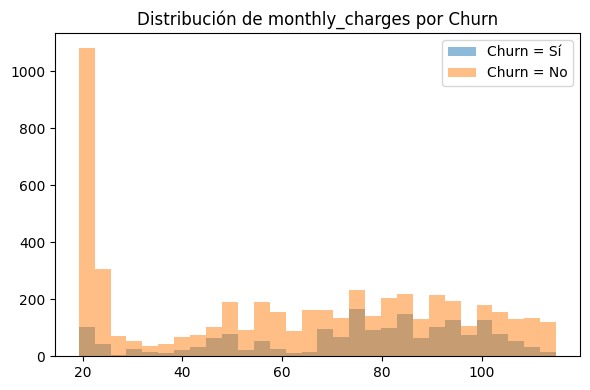

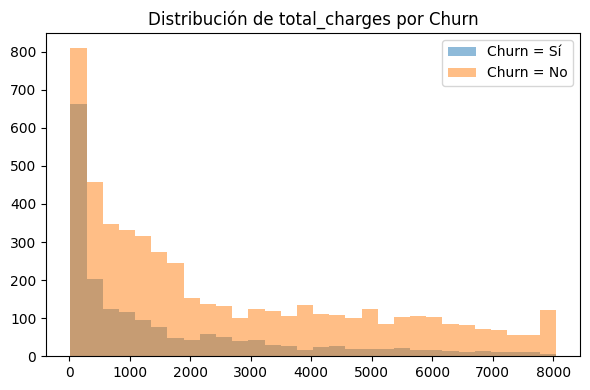

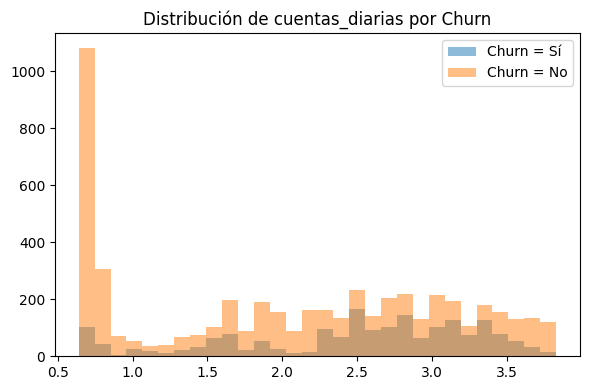


== Tasa de churn por contract_type (Top) ==


,contract_type,churn_rate
0,Month-to-month,0.427097
1,One year,0.112695
2,Two year,0.028319



== Tasa de churn por payment_method (Top) ==


,payment_method,churn_rate
0,Electronic check,0.452854
1,Mailed check,0.191067
2,Bank transfer (automatic),0.167098
3,Credit card (automatic),0.152431



== Tasa de churn por internet_service (Top) ==


,internet_service,churn_rate
0,Fiber optic,0.418928
1,DSL,0.189591
2,No,0.074050



== Tasa de churn por paperless_billing (Top) ==


,paperless_billing,churn_rate
0,Yes,0.335651
1,No,0.163301



== Tasa de churn por gender (Top) ==


,gender,churn_rate
0,Female,0.269209
1,Male,0.261603



[INFO] Correlación (Pearson) de numéricos con churn_bin:


,churn_bin,cuentas_diarias,monthly_charges,paperless_billing_bin,senior_citizen,streaming_tv_bin,streaming_movies_bin,multiple_lines_bin,phone_service_bin,device_protection_bin,online_backup_bin,partner_bin,dependents_bin,tech_support_bin,online_security_bin,total_charges,tenure_months
corr,1.0,0.193605,0.193605,0.191825,0.150889,0.063228,0.061382,0.040102,0.011942,-0.06616,-0.082255,-0.150448,-0.164221,-0.164674,-0.171226,-0.198359,-0.352229


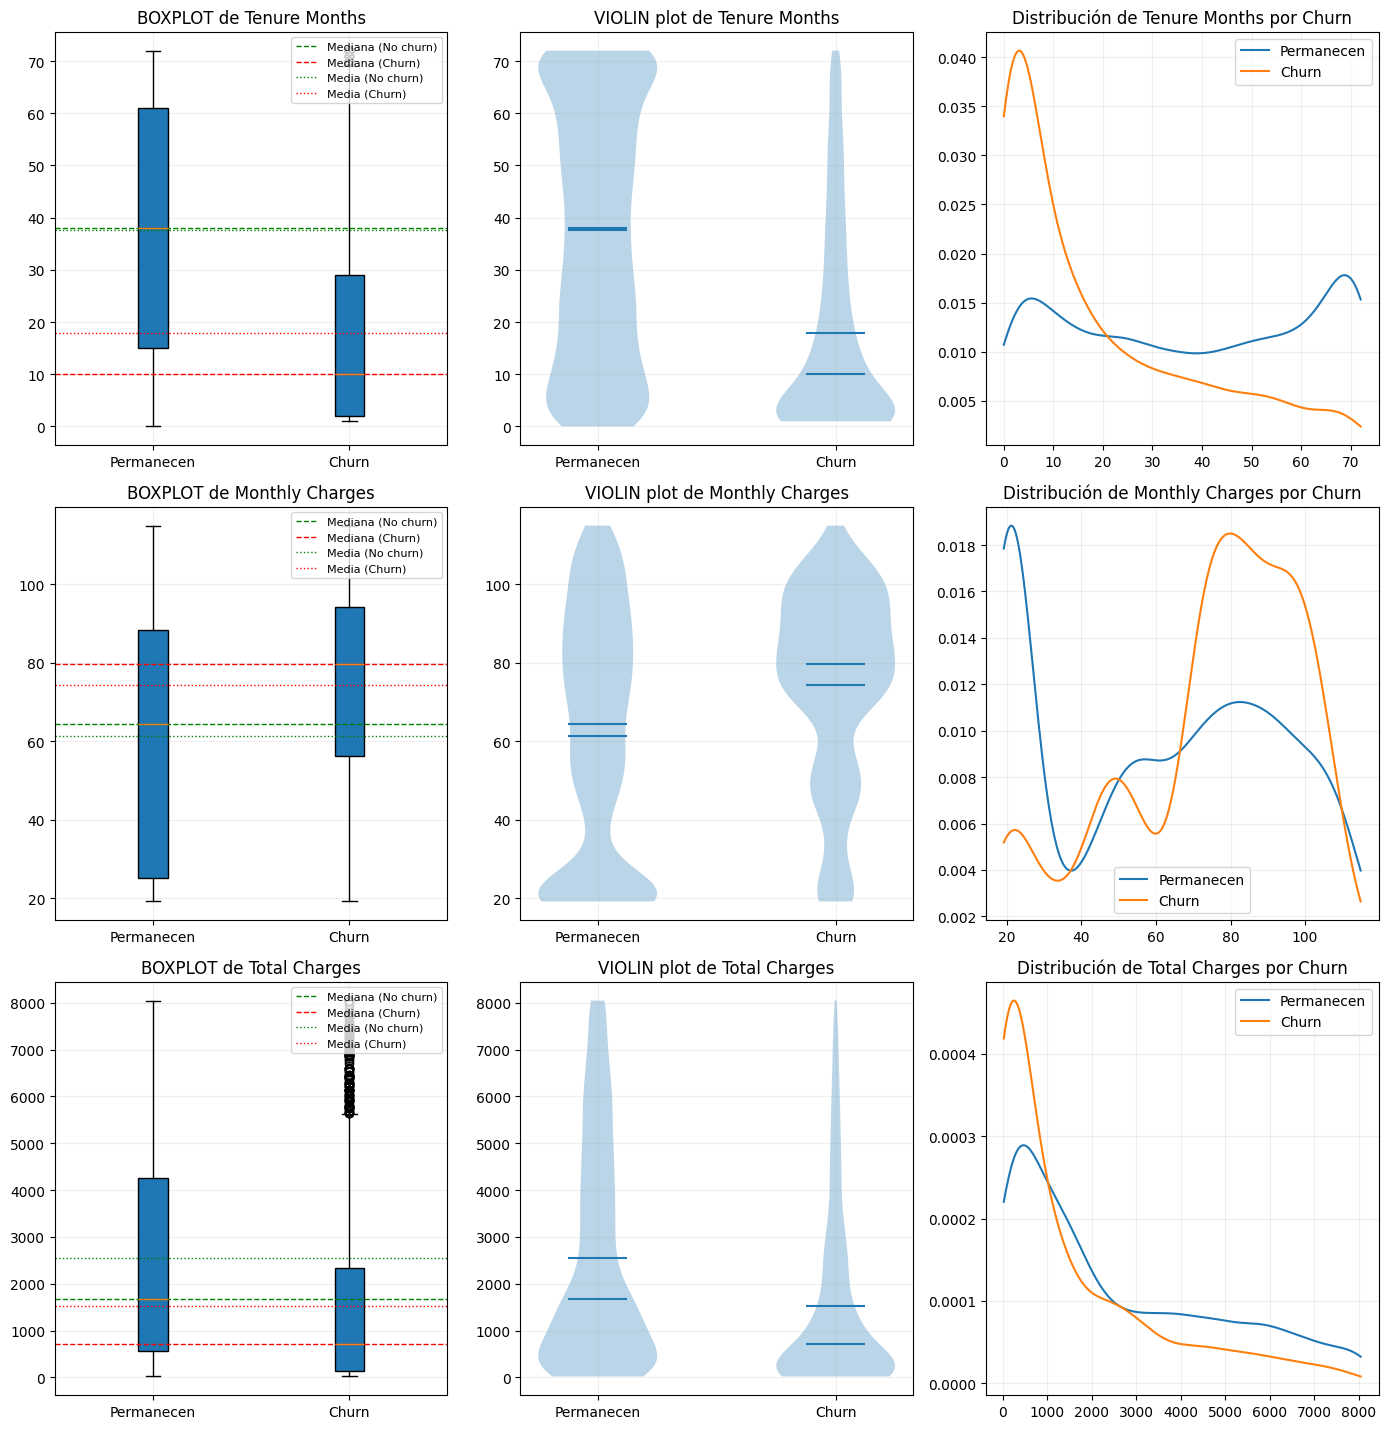

In [19]:
# ==========================
# CARGA Y ANÁLISIS (EDA)
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_eda = df_ready.copy()

# ------------------------------------------------------------
# 0) Arreglos ligeros de "no aplica" -> 0 en binarios
# ------------------------------------------------------------
def to_low_str(s):
    return s.astype(str).str.strip().str.lower()

if "internet_service" in df_eda.columns:
    no_internet = to_low_str(df_eda["internet_service"]).isin(["no internet service","none","no"])
    internet_deps = [
        "online_security_bin","online_backup_bin","device_protection_bin",
        "tech_support_bin","streaming_tv_bin","streaming_movies_bin"
    ]
    for c in internet_deps:
        if c in df_eda.columns:
            df_eda.loc[no_internet & df_eda[c].isna(), c] = 0

if "phone_service" in df_eda.columns and "multiple_lines_bin" in df_eda.columns:
    no_phone = to_low_str(df_eda["phone_service"]).isin(["no","0","false"])
    df_eda.loc[no_phone & df_eda["multiple_lines_bin"].isna(), "multiple_lines_bin"] = 0

# Asegura churn_bin desde churn si faltó algo
if "churn_bin" in df_eda.columns and df_eda["churn_bin"].isna().any() and "churn" in df_eda.columns:
    map_churn = {"yes":1,"si":1,"sí":1,"true":1,"1":1,"no":0,"false":0,"0":0}
    df_eda.loc[df_eda["churn_bin"].isna(), "churn_bin"] = to_low_str(df_eda["churn"]).map(map_churn)

# ------------------------------------------------------------
# 1) Resumen rápido
# ------------------------------------------------------------
print("[INFO] Nulos por columna (Top 10) tras ajustes:")
display(df_eda.isna().sum().sort_values(ascending=False).head(10))

num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = sorted([c for c in df_eda.columns if c not in num_cols])

print("\n[INFO] Descriptivo numérico:")
display(df_eda[num_cols].describe().T)

# ------------------------------------------------------------
# 2) Métrica de churn global
# ------------------------------------------------------------
churn_rate = np.nan
if "churn_bin" in df_eda.columns:
    churn_rate = float(df_eda["churn_bin"].mean())
    print(f"\n[INFO] Churn global (aprox): {churn_rate:.2%}")

# ------------------------------------------------------------
# 3) Gráficas
# ------------------------------------------------------------

# 3.1 Distribución de churn
if "churn" in df_eda.columns:
    plt.figure(figsize=(4,4))
    to_low_str(df_eda["churn"]).map({"yes":"Yes","si":"Yes","sí":"Yes","true":"Yes","1":"Yes",
                                     "no":"No","false":"No","0":"No"}).value_counts().plot(
        kind="pie", autopct="%1.1f%%", ylabel=""
    )
    plt.title("Distribución de Churn")
    plt.tight_layout(); plt.show()

# 3.2 Barras apiladas: churn por categóricas clave
def stacked_bar_counts(d, col):
    if "churn" not in d.columns or col not in d.columns:
        return
    tmp = (d[[col,"churn"]]
           .dropna()
           .assign(churn=lambda x: to_low_str(x["churn"]).map(
               {"yes":"Yes","si":"Yes","sí":"Yes","true":"Yes","1":"Yes","no":"No","false":"No","0":"No"}))
           .groupby([col,"churn"]).size().reset_index(name="count"))
    piv = tmp.pivot(index=col, columns="churn", values="count").fillna(0)
    piv.plot(kind="bar", stacked=True, figsize=(6,4))
    plt.title(f"Churn por {col}")
    plt.xticks(rotation=30, ha="right"); plt.tight_layout(); plt.show()
    return piv

for c in ["gender","contract_type","payment_method","internet_service","paperless_billing"]:
    if c in df_eda.columns:
        _ = stacked_bar_counts(df_eda, c)

# 3.3 Numéricos por churn (hist superpuesto)
def hist_por_churn(d, col, bins=30):
    if "churn_bin" not in d.columns or col not in d.columns:
        return
    ok = d.dropna(subset=[col, "churn_bin"])
    vals_si = ok.loc[ok["churn_bin"] == 1, col]
    vals_no = ok.loc[ok["churn_bin"] == 0, col]
    plt.figure(figsize=(6,4))
    plt.hist(vals_si, bins=bins, alpha=0.5, label="Churn = Sí")
    plt.hist(vals_no, bins=bins, alpha=0.5, label="Churn = No")
    plt.title(f"Distribución de {col} por Churn")
    plt.legend(); plt.tight_layout(); plt.show()

for c in ["tenure_months","monthly_charges","total_charges","cuentas_diarias"]:
    if c in df_eda.columns:
        hist_por_churn(df_eda, c)

# ------------------------------------------------------------
# 4) Tablas de tasa de churn por categoría
# ------------------------------------------------------------
def churn_rate_by(d, col):
    if "churn_bin" not in d.columns or col not in d.columns:
        return pd.DataFrame()
    out = (d[[col,"churn_bin"]]
           .dropna(subset=[col])
           .groupby(col)["churn_bin"].mean().sort_values(ascending=False).reset_index())
    out = out.rename(columns={"churn_bin":"churn_rate"})
    return out

for c in ["contract_type","payment_method","internet_service","paperless_billing","gender"]:
    if c in df_eda.columns:
        tbl = churn_rate_by(df_eda, c)
        if not tbl.empty:
            print(f"\n== Tasa de churn por {c} (Top) ==")
            display(tbl.head(10))

# ------------------------------------------------------------
# 5) Correlación de numéricos con churn_bin (señal rápida)
# ------------------------------------------------------------
if "churn_bin" in df_eda.columns:
    corr_vs_churn = df_eda[num_cols].corrwith(df_eda["churn_bin"]).sort_values(ascending=False)
    print("\n[INFO] Correlación (Pearson) de numéricos con churn_bin:")
    display(corr_vs_churn.to_frame("corr").T if corr_vs_churn.ndim==1 else corr_vs_churn)


# ------------------------------------------------------------
# 6) Boxplot + Violin + KDE por estado de Churn (comparativos)
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Usaremos df_eda ya creado arriba
D = df_eda.copy()

# Asegura churn_bin
def _to_low(s): return s.astype(str).str.strip().str.lower()
if "churn_bin" not in D.columns or D["churn_bin"].isna().any():
    D["churn_bin"] = _to_low(D["churn"]).map({
        "yes":1,"si":1,"sí":1,"true":1,"1":1,
        "no":0,"false":0,"0":0
    })

# Intentamos KDE con scipy; si no está, caemos a histogramas
try:
    from scipy.stats import gaussian_kde
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

features = [col for col in ["tenure_months","monthly_charges","total_charges"] if col in D.columns]
nrows = len(features)
if nrows:
    fig, axes = plt.subplots(nrows, 3, figsize=(14, 4.8*nrows))
    if nrows == 1:
        axes = np.array([axes])  # homogeneizar índice

    def _plot_row(ax_box, ax_violin, ax_kde, col):
        a = D.loc[D["churn_bin"]==0, col].dropna()  # Permanecen
        b = D.loc[D["churn_bin"]==1, col].dropna()  # Churn

        # --- BOX ---
        bp = ax_box.boxplot([a, b], labels=["Permanecen","Churn"], showfliers=True, patch_artist=True)
        ax_box.set_title(f"BOXPLOT de {col.replace('_',' ').title()}")
        # medias/medianas de referencia
        m0, m1 = float(np.nanmedian(a)), float(np.nanmedian(b))
        mu0, mu1 = float(np.nanmean(a)), float(np.nanmean(b))
        ax_box.axhline(m0, color="green", linestyle="--", linewidth=1, label="Mediana (No churn)")
        ax_box.axhline(m1, color="red",   linestyle="--", linewidth=1, label="Mediana (Churn)")
        ax_box.axhline(mu0, color="green", linestyle=":", linewidth=1, label="Media (No churn)")
        ax_box.axhline(mu1, color="red",   linestyle=":", linewidth=1, label="Media (Churn)")
        ax_box.legend(loc="upper right", fontsize=8)
        ax_box.grid(alpha=0.2)

        # --- VIOLIN ---
        parts = ax_violin.violinplot([a, b], showmeans=True, showmedians=True, showextrema=False)
        ax_violin.set_xticks([1,2]); ax_violin.set_xticklabels(["Permanecen","Churn"])
        ax_violin.set_title(f"VIOLIN plot de {col.replace('_',' ').title()}")
        ax_violin.grid(alpha=0.2)

        # --- KDE / HIST ---
        ax_kde.set_title(f"Distribución de {col.replace('_',' ').title()} por Churn")
        if _HAVE_SCIPY and len(a) > 1 and len(b) > 1:
            xs = np.linspace(min(a.min(), b.min()), max(a.max(), b.max()), 300)
            ax_kde.plot(xs, gaussian_kde(a)(xs), label="Permanecen")
            ax_kde.plot(xs, gaussian_kde(b)(xs), label="Churn")
        else:
            ax_kde.hist(a, bins=30, alpha=0.5, label="Permanecen", density=True)
            ax_kde.hist(b, bins=30, alpha=0.5, label="Churn", density=True)
        ax_kde.legend(); ax_kde.grid(alpha=0.2)

    for i, col in enumerate(features):
        _plot_row(axes[i,0], axes[i,1], axes[i,2], col)

    plt.tight_layout()
    plt.show()

else:
    print("No se encontraron columnas numéricas esperadas para los plots comparativos.")



#📄Informe final

In [18]:
# ==========================
# INFORME FINAL (Markdown)
# ==========================
from datetime import datetime
from textwrap import dedent
from IPython.display import Markdown, display
import pandas as pd
import numpy as np

D = df_ready.copy()

def map_yesno(s):
    return s.astype(str).str.lower().map(
        {"yes":1,"si":1,"sí":1,"true":1,"1":1,"no":0,"false":0,"0":0}
    )

# Asegura churn_bin
if "churn_bin" not in D.columns or D["churn_bin"].isna().any():
    D["churn_bin"] = map_yesno(D["churn"])

def churn_rate_by(d, col):
    if col not in d.columns: return pd.DataFrame()
    out = (d[[col,"churn_bin"]]
           .dropna(subset=[col])
           .groupby(col)["churn_bin"].mean()
           .sort_values(ascending=False)
           .reset_index()
           .rename(columns={"churn_bin":"churn_rate"}))
    out["churn_rate"] = (out["churn_rate"]*100).round(2)
    return out

# -------- KPIs comparativos (dinámicos) --------
def safe_median(s):
    try: return float(np.nanmedian(s))
    except: return np.nan
def safe_mean(s):
    try: return float(np.nanmean(s))
    except: return np.nan

g = D.groupby("churn_bin", dropna=False)
tenure_med_no  = safe_median(g["tenure_months"].get_group(0)) if "tenure_months" in D else np.nan
tenure_med_yes = safe_median(g["tenure_months"].get_group(1)) if "tenure_months" in D else np.nan
monthly_mean_no  = safe_mean(g["monthly_charges"].get_group(0)) if "monthly_charges" in D else np.nan
monthly_mean_yes = safe_mean(g["monthly_charges"].get_group(1)) if "monthly_charges" in D else np.nan

# Tablas de churn por categoría
tbl_contract  = churn_rate_by(D, "contract_type")
tbl_payment   = churn_rate_by(D, "payment_method")
tbl_internet  = churn_rate_by(D, "internet_service")
tbl_paperless = churn_rate_by(D, "paperless_billing")
tbl_gender    = churn_rate_by(D, "gender")

# Correlaciones con churn_bin
num_cols = D.select_dtypes(include=[np.number]).columns.tolist()
corr_all = D[num_cols].corrwith(D["churn_bin"]).round(3)
corr_tbl = corr_all.sort_values(ascending=False).reset_index()
corr_tbl.columns = ["feature","corr_vs_churn"]

corr_tenure  = float(corr_all.get("tenure_months", np.nan))
corr_monthly = float(corr_all.get("monthly_charges", np.nan))
corr_total   = float(corr_all.get("total_charges", np.nan))

# -------- Markdown --------
now_str = datetime.now().strftime("%Y-%m-%d %H:%M")
n_rows  = len(D)
churn_global = float(D["churn_bin"].mean())*100

md = []
md.append("# Telecom X — Informe de Evasión (Churn)\n")
md.append(f"*Generado:* {now_str}\n")

md.append("## 1. Introducción\n")
md.append(dedent("""
Este informe resume el análisis de evasión (churn) con datos cargados desde JSON (API simulada).
Incluye: limpieza/estandarización, creación de `Cuentas_Diarias`, EDA y hallazgos clave.
"""))

md.append("## 2. Limpieza y Preparación\n")
md.append(dedent("""
- Aplanado de campos anidados (`customer`, `phone`, `internet`, `account`).
- Renombrado a *snake_case* y tipificación numérica (`monthly_charges`, `total_charges`, `tenure_months`).
- Homologación **Sí/No → 1/0** en columnas *_bin*.
- Imputación de `total_charges` cuando faltó (`monthly_charges * tenure_months`) y recorte leve de outliers.
- Creación de **`Cuentas_Diarias = monthly_charges / 30`**.
"""))

md.append("## 3. EDA — Resultados principales\n")
md.append(f"- **Tamaño del dataset:** {n_rows:,} filas.\n")
md.append(f"- **Churn global (aprox.):** {churn_global:.1f}%\n")

# Comparativos de distribución
md.append("\n**Comparativos clave (Churn vs No Churn):**\n")
md.append(f"- **Tenure mediano:** *Churn* ≈ **{tenure_med_yes:.0f}** meses vs *No Churn* ≈ **{tenure_med_no:.0f}** meses.")
md.append(f"- **Cargos mensuales promedio:** *Churn* ≈ **{monthly_mean_yes:.2f}** vs *No Churn* ≈ **{monthly_mean_no:.2f}**.")
md.append(f"- **Correlaciones (Pearson) con `churn_bin`** → tenure: **{corr_tenure:+.3f}**, monthly: **{corr_monthly:+.3f}**, total: **{corr_total:+.3f}**.\n")

md.append("**Tasa de churn por contrato (Top):**\n")
if not tbl_contract.empty: md.append(tbl_contract.to_markdown(index=False))
md.append("\n\n**Tasa de churn por método de pago (Top):**\n")
if not tbl_payment.empty: md.append(tbl_payment.to_markdown(index=False))
md.append("\n\n**Tasa de churn por tipo de internet (Top):**\n")
if not tbl_internet.empty: md.append(tbl_internet.to_markdown(index=False))
md.append("\n\n**Tasa de churn por paperless_billing:**\n")
if not tbl_paperless.empty: md.append(tbl_paperless.to_markdown(index=False))
md.append("\n\n**Tasa de churn por género:**\n")
if not tbl_gender.empty: md.append(tbl_gender.to_markdown(index=False))

md.append("\n\n**Correlación (Pearson) de numéricos con `churn_bin` (ordenado):**\n")
md.append(corr_tbl.to_markdown(index=False))

md.append("\n## 4. Conclusiones e Insights\n")
md.append(dedent(f"""
- **Antigüedad** es el principal protector: `corr = {corr_tenure:+.3f}`; los clientes nuevos churnean más.
- **Contrato**: *Month-to-month* concentra la mayor tasa de churn; **1–2 años** retienen mejor.
- **Pago**: *Electronic check* es el más riesgoso; **autopagos** (tarjeta/transferencia) muestran menor churn.
- **Internet**: *Fiber optic* aparece con mayor churn; revisar precio/experiencia/soporte de ese segmento.
- **Precio/uso**: `monthly_charges` y `cuentas_diarias` correlacionan positivamente con churn (≈ {corr_monthly:+.3f}); posible brecha de **valor percibido**.
- **Servicios de valor** (`online_security`, `tech_support`) se asocian a **menor** churn.
"""))

md.append("### Notas\n")
md.append(dedent("""
- **Causalidad vs. asociación**: las diferencias observadas no implican causalidad.
- **Paperless billing** suele estar mezclado con **contrato mensual** y **e-check**; no asumir relación directa sin modelado.
"""))

md.append("## 5. Recomendaciones\n")
md.append(dedent("""
1) **Retención temprana (0–6 meses)**: onboarding guiado, check-ins, bonos de lealtad; priorizar tenure bajo + cargos altos.
2) **Migración de contrato**: ofertas para pasar de *month-to-month* a **1–2 años** (descuentos por permanencia, upgrades/bundles).
3) **Fomentar pagos automáticos** (tarjeta/transferencia) con incentivos y UX sin fricción.
4) **Paquetes de valor** en clientes de **fibra óptica** y **precio alto**: incluir `online_security`/`tech_support`.
5) **Alertas** ante subidas de `monthly_charges` sin mejora percibida y ante incidencias tempranas.
"""))

# (Opcional) Inserta tu imagen comparativa si la guardaste:
# md.append("\n![EDA comparativo](outputs/eda_box_violin_kde.png)\n")

report_md = "\n".join(md)
display(Markdown(report_md))

with open("informe_churn_telecomx.md","w",encoding="utf-8") as f:
    f.write(report_md)
print("[OK] Informe guardado en informe_churn_telecomx.md")


# Telecom X — Informe de Evasión (Churn)

*Generado:* 2025-08-17 06:58

## 1. Introducción


Este informe resume el análisis de evasión (churn) con datos cargados desde JSON (API simulada).
Incluye: limpieza/estandarización, creación de `Cuentas_Diarias`, EDA y hallazgos clave.

## 2. Limpieza y Preparación


- Aplanado de campos anidados (`customer`, `phone`, `internet`, `account`).
- Renombrado a *snake_case* y tipificación numérica (`monthly_charges`, `total_charges`, `tenure_months`).
- Homologación **Sí/No → 1/0** en columnas *_bin*.
- Imputación de `total_charges` cuando faltó (`monthly_charges * tenure_months`) y recorte leve de outliers.
- Creación de **`Cuentas_Diarias = monthly_charges / 30`**.

## 3. EDA — Resultados principales

- **Tamaño del dataset:** 7,267 filas.

- **Churn global (aprox.):** 26.5%


**Comparativos clave (Churn vs No Churn):**

- **Tenure mediano:** *Churn* ≈ **10** meses vs *No Churn* ≈ **38** meses.
- **Cargos mensuales promedio:** *Churn* ≈ **74.44** vs *No Churn* ≈ **61.25**.
- **Correlaciones (Pearson) con `churn_bin`** → tenure: **-0.352**, monthly: **+0.194**, total: **-0.198**.

**Tasa de churn por contrato (Top):**

| contract_type   |   churn_rate |
|:----------------|-------------:|
| Month-to-month  |        42.71 |
| One year        |        11.27 |
| Two year        |         2.83 |


**Tasa de churn por método de pago (Top):**

| payment_method            |   churn_rate |
|:--------------------------|-------------:|
| Electronic check          |        45.29 |
| Mailed check              |        19.11 |
| Bank transfer (automatic) |        16.71 |
| Credit card (automatic)   |        15.24 |


**Tasa de churn por tipo de internet (Top):**

| internet_service   |   churn_rate |
|:-------------------|-------------:|
| Fiber optic        |        41.89 |
| DSL                |        18.96 |
| No                 |         7.4  |


**Tasa de churn por paperless_billing:**

| paperless_billing   |   churn_rate |
|:--------------------|-------------:|
| Yes                 |        33.57 |
| No                  |        16.33 |


**Tasa de churn por género:**

| gender   |   churn_rate |
|:---------|-------------:|
| Female   |        26.92 |
| Male     |        26.16 |


**Correlación (Pearson) de numéricos con `churn_bin` (ordenado):**

| feature               |   corr_vs_churn |
|:----------------------|----------------:|
| churn_bin             |           1     |
| cuentas_diarias       |           0.194 |
| monthly_charges       |           0.194 |
| paperless_billing_bin |           0.192 |
| senior_citizen        |           0.151 |
| multiple_lines_bin    |           0.04  |
| phone_service_bin     |           0.012 |
| streaming_tv_bin      |          -0.037 |
| streaming_movies_bin  |          -0.04  |
| partner_bin           |          -0.15  |
| dependents_bin        |          -0.164 |
| device_protection_bin |          -0.177 |
| online_backup_bin     |          -0.196 |
| total_charges         |          -0.198 |
| tech_support_bin      |          -0.274 |
| online_security_bin   |          -0.281 |
| tenure_months         |          -0.352 |

## 4. Conclusiones e Insights


- **Antigüedad** es el principal protector: `corr = -0.352`; los clientes nuevos churnean más.
- **Contrato**: *Month-to-month* concentra la mayor tasa de churn; **1–2 años** retienen mejor.
- **Pago**: *Electronic check* es el más riesgoso; **autopagos** (tarjeta/transferencia) muestran menor churn.
- **Internet**: *Fiber optic* aparece con mayor churn; revisar precio/experiencia/soporte de ese segmento.
- **Precio/uso**: `monthly_charges` y `cuentas_diarias` correlacionan positivamente con churn (≈ +0.194); posible brecha de **valor percibido**.
- **Servicios de valor** (`online_security`, `tech_support`) se asocian a **menor** churn.

### Notas


- **Causalidad vs. asociación**: las diferencias observadas no implican causalidad. 
- **Paperless billing** suele estar mezclado con **contrato mensual** y **e-check**; no asumir relación directa sin modelado.

## 5. Recomendaciones


1) **Retención temprana (0–6 meses)**: onboarding guiado, check-ins, bonos de lealtad; priorizar tenure bajo + cargos altos.
2) **Migración de contrato**: ofertas para pasar de *month-to-month* a **1–2 años** (descuentos por permanencia, upgrades/bundles).
3) **Fomentar pagos automáticos** (tarjeta/transferencia) con incentivos y UX sin fricción.
4) **Paquetes de valor** en clientes de **fibra óptica** y **precio alto**: incluir `online_security`/`tech_support`.
5) **Alertas** ante subidas de `monthly_charges` sin mejora percibida y ante incidencias tempranas.


[OK] Informe guardado en informe_churn_telecomx.md
